In [1]:
import os
os.chdir('/Users/kinoshitashouhei/Desktop/competitions/05_Prob_Space/accommodation_charge_prediction/')

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import warnings
from src.config import *

warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('input/train_data.csv', parse_dates=[COL_LAST_REVIEW], dtype=DICT_DTYPES)
df_test = pd.read_csv('input/test_data.csv', parse_dates=[COL_LAST_REVIEW], dtype=DICT_DTYPES)
df_station_list = pd.read_csv('input/station_list.csv')
sample_sub = pd.read_csv('input/submission.csv')

##### データサイズ

In [4]:
print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')
print(f'df_station_list shape: {df_station_list.shape}')

df_train shape: (9990, 13)
df_test shape: (4996, 12)
df_station_list shape: (203, 3)


In [5]:
df_train.head(3)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y
0,1,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,242899459,Koto Ku,35.68185,139.80310,Entire home/apt,1,55,2020-04-25,2.21,173,12008
1,2,Downtown Tokyo Iriya next to Ueno,308879948,Taito Ku,35.72063,139.78536,Entire home/apt,6,72,2020-03-25,2.11,9,6667
2,3,"Japan Style,Private,Affordable,4min to Sta.",300877823,Katsushika Ku,35.74723,139.82349,Entire home/apt,1,18,2020-03-23,3.46,288,9923


In [6]:
df_test.head(3)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
0,1,"5-minute walk from Akasaka Sta, Superior double",184730720,Minato Ku,35.67131,139.73285,Private room,1,0,NaT,NaN,183
1,2,7 min Sta.-Center of IKEBUKURO Cozy Room#503,20993205,Toshima Ku,35.73014,139.71739,Entire home/apt,2,21,2020-04-16,1.94,337
2,3,Designer'sApt 1min sta☆Shinjuku 7min☆Shibuya 4min,322521715,Setagaya Ku,35.66193,139.66540,Entire home/apt,1,14,2020-02-12,0.82,240


In [12]:
df_station_list.head(3)

,station_name,longitude,latitude
0,東京,139.766103,35.681391
1,新橋,139.758587,35.666195
2,品川,139.738999,35.628760


##### 欠損値の確認

In [11]:
pd.concat([pd.DataFrame(df_train.isnull().sum(), columns=['train']),
           pd.DataFrame(df_test.isnull().sum(), columns=['test'])], axis=1)

,train,test
id,0,0.0
name,0,0.0
host_id,0,0.0
neighbourhood,0,0.0
latitude,0,0.0
longitude,0,0.0
room_type,0,0.0
minimum_nights,0,0.0
number_of_reviews,0,0.0
last_review,1699,832.0


#### NAME
 - 重複している名前がいくつかある
 - 名前が同じでも、他の情報が若干異なる(yも異なる)
 - 正規表現で最寄りの駅と距離を取得できそう

In [19]:
c = collections.Counter(list(df_train[COL_NAME].values))

In [22]:
df_train.query(f'{COL_NAME} == "Quiet residential Shinjuku area,8 min on foot Sta"').head(3)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y
5,6,"Quiet residential Shinjuku area,8 min on foot Sta",247956261,Shinjuku Ku,35.71273,139.69687,Entire home/apt,2,30,2020-03-29,5.20,335,8404
1003,1004,"Quiet residential Shinjuku area,8 min on foot Sta",247956261,Shinjuku Ku,35.71260,139.69883,Entire home/apt,2,30,2020-04-05,5.17,325,7651
1457,1458,"Quiet residential Shinjuku area,8 min on foot Sta",247956261,Shinjuku Ku,35.71335,139.69901,Entire home/apt,2,24,2020-04-07,4.77,292,7887


#### neighbourhood
所在地（東京都の23の特別区のいずれか）  
 - ラベルエンコードでよい？

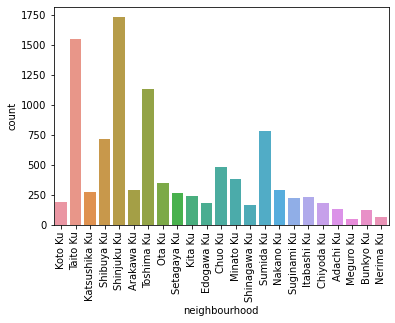

In [26]:
sns.countplot(df_train[COL_NEIGHBOURHOOD])
plt.xticks(rotation=90)
plt.show()

#### 緯度、軽度
 - 緯度、軽度とstation_listの緯度、軽度から距離を計算して最寄りの駅を特徴量にできそう

#### room_type

In [29]:
df_train.groupby(COL_ROOM_TYPE).agg({COL_Y: ['median', 'mean', 'std']})

y                             
                  median          mean            std
room_type                                            
Entire home/apt  13869.5  29799.554928   73629.915206
Hotel room       10081.0  30752.153420  101631.140562
Private room      7547.0  12403.012591   24244.490170
Shared room       3479.0   6052.311983    8679.716243

#### minimum_night
最短宿泊日数

In [30]:
df_train[[COL_MINIMUM_NIGHTS]].describe()

,minimum_nights
count,9990.000000
mean,3.331331
std,8.504451
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,365.000000


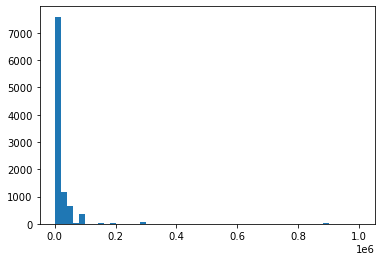

In [47]:
plt.hist(df_train[COL_Y], bins=50)
plt.show()

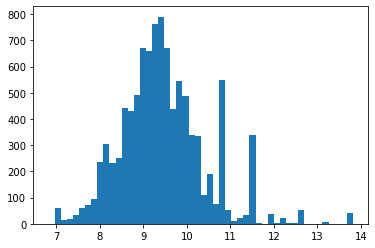

In [48]:
plt.hist(df_train['log_y'], bins=50)
plt.show()

In [36]:
df_train['log_y'] = np.log(df_train[COL_Y])

In [37]:
df_train[[COL_MINIMUM_NIGHTS, 'log_y']].corr()

,minimum_nights,log_y
minimum_nights,1.000000,-0.123321
log_y,-0.123321,1.000000


In [42]:
tmp_y = np.exp(df_train['log_y'])

In [43]:
tmp_y

0        12008.0
1         6667.0
2         9923.0
3         8109.0
4       100390.0
          ...   
9985     13505.0
9986      3279.0
9987     14898.0
9988      3950.0
9989     45041.0
Name: log_y, Length: 9990, dtype: float64

In [44]:
df_train[COL_Y]

0        12008
1         6667
2         9923
3         8109
4       100390
         ...  
9985     13505
9986      3279
9987     14898
9988      3950
9989     45041
Name: y, Length: 9990, dtype: int64

#### number_of_reviews

In [51]:
df_train[[COL_NUMBER_OF_REVIEWS]].describe()

,number_of_reviews
count,9990.000000
mean,25.943143
std,40.586283
min,0.000000
25%,2.000000
50%,11.000000
75%,33.000000
max,529.000000


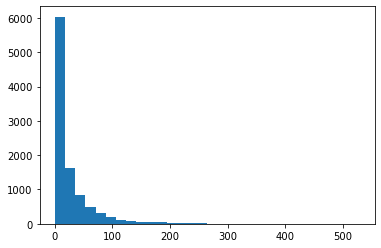

In [53]:
plt.hist(df_train[COL_NUMBER_OF_REVIEWS], bins=30)
plt.show()

#### 最終評価日
 - NULL存在する

In [54]:
df_train[[COL_REVIEWS_PER_MONTH]].describe()

,reviews_per_month
count,8291.000000
mean,1.700127
std,1.402640
min,0.020000
25%,0.680000
50%,1.480000
75%,2.420000
max,43.600000


In [55]:
df_train[[COL_LAST_REVIEW]].describe()

,last_review
count,8291
unique,546
top,2020-03-22 00:00:00
freq,117
first,2016-11-19 00:00:00
last,2020-04-29 00:00:00


#### 経過日数を特徴量にする？

In [58]:
df_train[[COL_LAST_REVIEW, COL_Y]].sort_values(by=COL_LAST_REVIEW, ascending=False).head(3)

,last_review,y
179,2020-04-29,12518
684,2020-04-29,14990
2831,2020-04-29,7995


In [59]:
df_train[[COL_LAST_REVIEW, COL_Y]].sort_values(by=COL_LAST_REVIEW, ascending=True).head(3)

,last_review,y
4077,2016-11-19,8069
8204,2017-04-12,8067
3277,2017-04-29,7810


In [60]:
df_train[[COL_AVAILABILITY_365]].describe()

,availability_365
count,9990.000000
mean,157.202102
std,115.780646
min,0.000000
25%,63.000000
50%,154.000000
75%,248.000000
max,365.000000
